In [1]:
from burstextractor.burstlist import download_burst_list, process_burst_list
from burstextractor.timeutils import extract_time, fix_typos_in_time, fix_24_hour_time, create_datetime, check_valid_date, adjust_year_month
from burstextractor.data_utils import explode_instruments_long_clean_instruments, keep_only_type_I_to_VI
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 

## Create Dataframe with the Burstlists

In [2]:
years = [2021, 2022, 2023]
months = range(1, 12+1)
burst_list = []
for year in years:
    for month in months:
        if month > datetime.datetime.now().month and year == datetime.datetime.now().year:
            break
        download_burst_list(year, month)
        burst_list.append(process_burst_list(f"e-CALLISTO_{year}_{month:02}.txt"))
burst_list = pd.concat(burst_list).reset_index(drop=True)

/home/vincenzo/sunflare_prediction/burstextractor/burstlist.py:29: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(filename, sep="\t", index_col=False, encoding=ENCODING, names=col_names, engine="python", skiprows=skip_row_idxs, dtype=str)
/home/vincenzo/sunflare_prediction/burstextractor/burstlist.py:29: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(filename, sep="\t", index_col=False, encoding=ENCODING, names=col_names, engine="python", skiprows=skip_row_idxs, dtype=str)


In [3]:
burst_list.sample(5)

,date,time,type,instruments
4068,20221026,07:40-07:40,III,Australia-ASSA
3022,20220626,22:22-22:22,III,"ALASKA-COHOE, ALASKA-HAARP, MEXICO-LANCE-A, ME..."
1939,20220318,12:15-12:15,III,"AUSTRIA-UNIGRAZ, Arecibo-Observatory, BIR, GLA..."
3594,20220828,16:26-17:57,RBR,"GERMANY-DLR, USA-ARIZONA-ERAU"
716,20210921,09:42-09:50,VI,"AUSTRIA-UNIGRAZ, BIR, EGYPT-Alexandria, SPAIN-..."


In [4]:
burst_list.shape

(4895, 4)

## Fix typos

In [5]:
extracted_digits = burst_list['time'].str.extract(r'(\d+).(\d+).(\d+).(\d+)', expand=True).astype(int)

In [6]:
impossible_times_bool = (extracted_digits[1] > 59) | (extracted_digits[3] > 59) | (extracted_digits[0] > 23) | (extracted_digits[2] > 23)
extracted_digits[impossible_times_bool]

,0,1,2,3
1693,6,6,6,88
2238,24,32,14,33
3876,23,59,24,0
3890,0,0,24,0
3920,3,50,24,0
4179,23,59,24,0
4467,23,58,24,0
4557,0,0,24,0
4576,0,0,24,0


In [7]:
burst_list[impossible_times_bool]

,date,time,type,instruments
1693,20220210,06:06-06:88,V,"ALMATY, Australia-ASSA, INDIA-OOTY, INDIA-UDAI..."
2238,20220421,24:32-14:33,III,"AUSTRIA-MICHELBACH, Arecibo-Observatory, GLASG..."
3876,20220926,23:59:24:00,III,"ALASKA-COHOE, ALASKA-HAARP, Australia-ASSA"
3890,20220929,00:00-24:00,NaN,CTM
3920,20221001,03:50-24:00,CTM,*
4179,20221110,23:59-24:00,III,"ALASKA-COHOE, Australia-ASSA"
4467,20221215,23:58-24:00,III,Arecibo-Observatory
4557,20221221,00:00-24:00,CTM,*
4576,20221222,00:00-24:00,CTM,*


In [8]:
burst_list.loc[4179]

date                               20221110
time                            23:59-24:00
type                                    III
instruments    ALASKA-COHOE, Australia-ASSA
Name: 4179, dtype: object

In [9]:
burst_list.loc[4179+1]

date                 20221111
time              00:02-00:14
type                       VI
instruments    Australia-ASSA
Name: 4180, dtype: object

In [10]:
burst_list = fix_typos_in_time(burst_list)
burst_list = extract_time(burst_list)
burst_list = fix_24_hour_time(burst_list)
burst_list = create_datetime(burst_list)
burst_list = explode_instruments_long_clean_instruments(burst_list)
burst_list = keep_only_type_I_to_VI(burst_list)

In [11]:
burst_list.sample(5)

,date,time,type,instruments,time_start,time_end,date_start,date_end,datetime_start,datetime_end
11060,20220511,18:39-18:50,II,MEXICO-LANCE-B,18:39,18:50,20220511,20220511,2022-05-11 18:39:00,2022-05-11 18:50:00
9718,20220430,04:56-05:00,III,INDIA-OOTY,04:56,05:00,20220430,20220430,2022-04-30 04:56:00,2022-04-30 05:00:00
21117,20221211,11:28-11:40,VI,SWISS-MUHEN,11:28,11:40,20221211,20221211,2022-12-11 11:28:00,2022-12-11 11:40:00
19398,20221011,11:01-11:11,II,INDIA-UDAIPUR,11:01,11:11,20221011,20221011,2022-10-11 11:01:00,2022-10-11 11:11:00
13497,20220627,12:05-12:12,III,BIR,12:05,12:12,20220627,20220627,2022-06-27 12:05:00,2022-06-27 12:12:00


## Fix wrong names

In [12]:
MIN_BURST_PER_INSTRUMENT = 2

In [13]:
low_appearance_instruments = burst_list.groupby('instruments').filter(lambda x: len(x) <= MIN_BURST_PER_INSTRUMENT).instruments.unique()
low_appearance_instruments

array(['INDIA-UAIPUR', 'ROSWELL-NW', 'DENMARK. GLASGOW', 'INPE?', 'MRT',
       'INDIA-GAURI?', 'AUSTRTIA-MICHELBACH', '/INDIA-UDAIPUR',
       'l MONGOLIA-UB', 'SWISS-Landschlach', 'HUMAIN. SWISS-Landschlacht',
       'GASGOW', 'INDOENSIA', 'DENMAARK',
       'SWISS-LandschlachtEGYPT-Alexandria', 'INDIA-UDAIPUR MRT1',
       'NORWAY-NY-AALESUND', 'SP', 'IAIN-PERALEJOS', 'HUAMAIN',
       'NDIA-GAURI', 'HUMAIn', 'MRT1?', 'HUMAI', 'NDIA-UDAIPUR',
       'LASKA-COHOE', 'NDIA-OOTY', 'MEXARFT', 'POLAND', 'USTRIA-UNIGRAZ',
       'MRT21', 'THAILAND-Pathumthan', 'INDIAMONGOLIA-UB', 'SSRT-UDAIPUR',
       '*', 'Australia-ASSAArecibo-Observatory',
       'SSRT {more like drifting chain of type I}', 'INDIAALMATY',
       'SSRT-GAURI', 'INDOALASKA-COHOE', 'ROSWELL-NMNESIA',
       'Australia-ASSA {followed by blackout}', 'SSRTMalaysia-Banting',
       'c'], dtype=object)

In [14]:
import difflib

In [15]:
def find_closest_instrument(instrument):
    try:
        instruments = burst_list.instruments.unique().tolist()
        instruments = np.setdiff1d(instruments, low_appearance_instruments)
        close_instrument = difflib.get_close_matches(instrument, instruments, n=1, cutoff=0.7)[0]
        print(f"Looking for a close match for {instrument}. Found {close_instrument}")
        return close_instrument
    except IndexError:
        print(f"Could not find a close match for {instrument}. Returning NaN.")
        return pd.NA

In [16]:
burst_list['instruments'] = burst_list['instruments'].apply(lambda x: find_closest_instrument(x) if x in low_appearance_instruments else x)

Looking for a close match for INDIA-UAIPUR. Found INDIA-UDAIPUR
Looking for a close match for INDIA-UAIPUR. Found INDIA-UDAIPUR
Looking for a close match for ROSWELL-NW. Found ROSWELL-NM
Looking for a close match for ROSWELL-NW. Found ROSWELL-NM
Looking for a close match for DENMARK. GLASGOW. Found GLASGOW
Looking for a close match for INPE?. Found INPE
Looking for a close match for MRT. Found MRT3
Looking for a close match for INDIA-GAURI?. Found INDIA-GAURI
Looking for a close match for AUSTRTIA-MICHELBACH. Found AUSTRIA-MICHELBACH
Looking for a close match for AUSTRTIA-MICHELBACH. Found AUSTRIA-MICHELBACH
Looking for a close match for /INDIA-UDAIPUR. Found INDIA-UDAIPUR
Looking for a close match for l MONGOLIA-UB. Found MONGOLIA-UB
Looking for a close match for l MONGOLIA-UB. Found MONGOLIA-UB
Looking for a close match for SWISS-Landschlach. Found SWISS-Landschlacht
Looking for a close match for HUMAIN. SWISS-Landschlacht. Found SWISS-Landschlacht
Looking for a close match for GASGO

In [17]:
burst_list[burst_list['instruments'].isna()]

,date,time,type,instruments,time_start,time_end,date_start,date_end,datetime_start,datetime_end
15846,20220723,20:33-20:35,III,NaN,20:33,20:35,20220723,20220723,2022-07-23 20:33:00,2022-07-23 20:35:00
21493,20221217,00:02-23:59,VI,<NA>,00:02,23:59,20221217,20221217,2022-12-17 00:02:00,2022-12-17 23:59:00
21609,20221218,16:22-16:23,III,NaN,16:22,16:23,20221218,20221218,2022-12-18 16:22:00,2022-12-18 16:23:00


In [18]:
burst_list = burst_list.dropna(subset=['instruments'])

In [19]:
burst_list.to_excel('burst_list.xlsx', index=False)

## Get some spectograms

In [20]:
from astropy.io import fits
from astropy.table import Table
from astropy.utils.data import get_pkg_data_filename

In [21]:
URL = 'http://soleil80.cs.technik.fhnw.ch/solarradio/data/2002-20yy_Callisto/2023/01/01/ALASKA-ANCHORAGE_20230101_000904_01.fit.gz'
data = Table.read(URL, format='fits')

In [22]:
data.info

<Table length=1>
   name    dtype   shape 
--------- ------- -------
     TIME float64 (3600,)
FREQUENCY float64  (200,)

In [23]:
from radiospectra.sources import CallistoSpectrogram

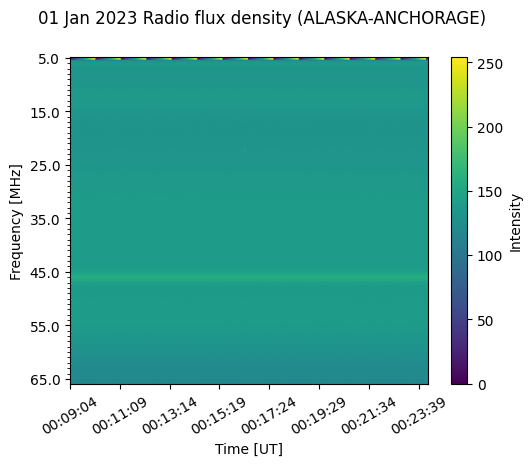

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [24]:
spec = CallistoSpectrogram.read(URL)
spec.peek()

In [25]:
np.quantile(spec.data, 0.01)

83.0

## Improve existing spectogram functions

In [26]:
from spectogram_utils import *

In [27]:
pd_data = spec_to_pd_dataframe(spec)
pd_data.head(5)

,65.875,65.56300354003906,65.25,64.93800354003906,64.625,64.31300354003906,64.0,63.6879997253418,63.375,63.0629997253418,...,6.5,6.188000202178955,5.875,5.563000202178955,5.25,5.0,5.0,5.0,5.0,5.0
2023-01-01 00:09:04.868,119,118,118,119,119,119,120,120,120,121,...,135,139,135,120,0,0,0,0,0,0
2023-01-01 00:09:05.118,120,119,118,119,119,119,120,120,121,121,...,136,139,135,120,1,1,1,1,1,1
2023-01-01 00:09:05.368,119,119,119,120,119,119,120,120,120,121,...,137,139,135,120,2,2,2,2,2,2
2023-01-01 00:09:05.618,119,118,119,119,120,119,120,120,121,121,...,136,138,135,120,3,3,3,3,3,3
2023-01-01 00:09:05.868,119,120,118,119,119,120,120,120,120,121,...,137,138,135,120,4,4,4,4,4,4


In [28]:
change_resolution_over_time(pd_data, 1800).head(5)

,65.875,65.56300354003906,65.25,64.93800354003906,64.625,64.31300354003906,64.0,63.6879997253418,63.375,63.0629997253418,...,6.5,6.188000202178955,5.875,5.563000202178955,5.25,5.0,5.0,5.0,5.0,5.0
2023-01-01 00:09:04.868000000,120,119,118,119,119,119,120,120,121,121,...,136,139,135,120,1,1,1,1,1,1
2023-01-01 00:09:05.368138966,119,119,119,120,120,119,120,120,121,121,...,137,139,135,120,3,3,3,3,3,3
2023-01-01 00:09:05.868277932,119,120,119,119,119,120,120,121,121,121,...,137,138,135,120,5,5,5,5,5,5
2023-01-01 00:09:06.368416898,119,119,119,119,119,119,120,120,120,122,...,136,139,135,120,7,7,7,7,7,7
2023-01-01 00:09:06.868555864,119,119,120,119,120,119,120,120,121,121,...,136,139,135,120,9,9,9,9,9,9


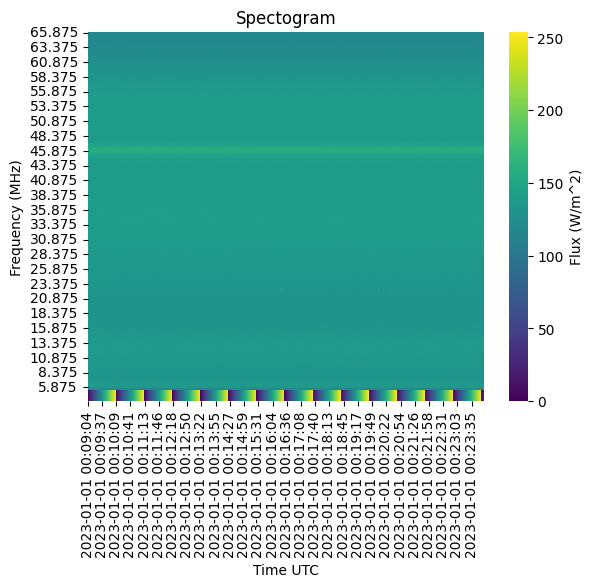

In [29]:
plot_spectogram(pd_data)

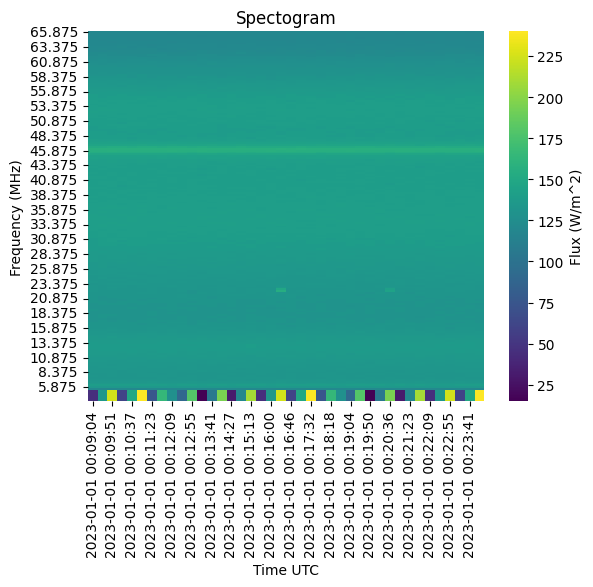

In [30]:
plot_spectogram(change_resolution_over_time(pd_data, 40))

In [31]:
spec.time_axis

array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 8.9925e+02, 8.9950e+02,
       8.9975e+02])

In [32]:
len(spec.freq_axis)

200

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

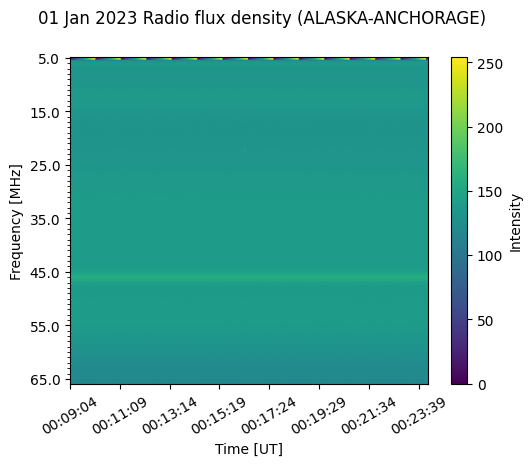

In [33]:
spec.plot()

In [34]:
spec.data.shape

(200, 3600)

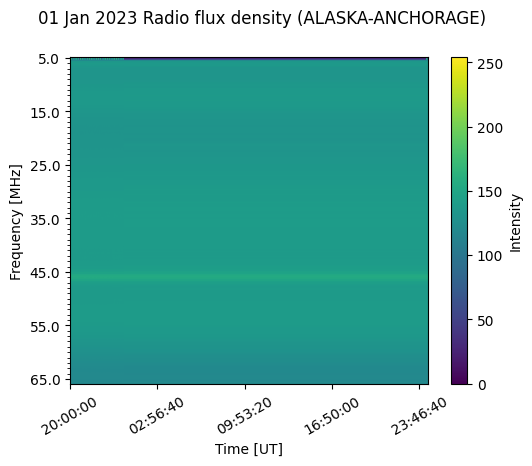

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [35]:
spec = CallistoSpectrogram.from_range('ALASKA-ANCHORAGE', '2023-01-01T20:00:00', '2023-01-02T04:50:00')
spec.peek()

In [36]:
def plot_spectogram(spectogram):
    spectogram = spectogram.copy()
    spectogram.index = spectogram.index.strftime('%Y-%m-%d %H:%M:%S')
    ax = sns.heatmap(spectogram.T, cmap='viridis', cbar_kws={'label': 'Flux (W/m^2)'})
    plt.title('Spectogram')
    plt.ylabel('Frequency (MHz)')
    plt.xlabel('Time UTC')
    plt.show()

In [37]:
pd_data.quantile()

65.875               119.0
65.56300354003906    119.0
65.25                119.0
64.93800354003906    119.0
64.625               119.0
                     ...  
5.0                  126.0
5.0                  126.0
5.0                  126.0
5.0                  126.0
5.0                  126.0
Name: 0.5, Length: 200, dtype: float64

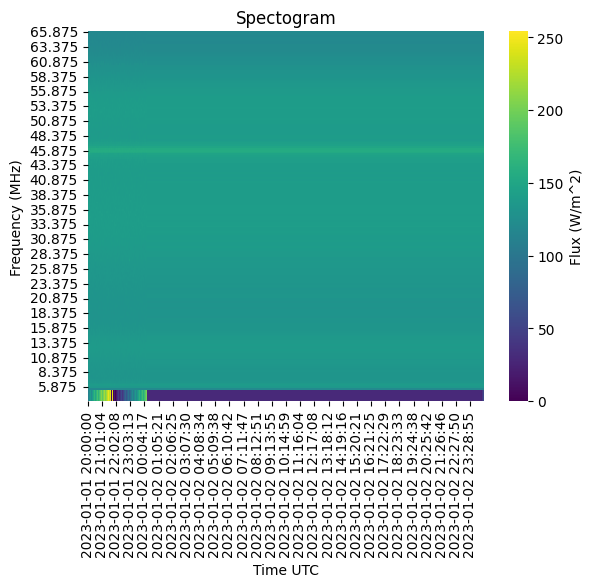

In [38]:
pd_data = spec_to_pd_dataframe(spec)
plot_spectogram(pd_data)

In [39]:
spec.data

array([[118, 119, 119, ..., 119, 119, 118],
       [119, 120, 119, ..., 120, 118, 119],
       [119, 118, 118, ..., 120, 118, 119],
       ...,
       [  0,   1,   2, ...,  17,  18,  19],
       [  0,   1,   2, ...,  17,  18,  19],
       [  0,   1,   2, ...,  17,  18,  19]], dtype=uint8)

In [40]:
pd_data.to_parquet('test.parquet')

ValueError: Duplicate column names found: ['65.875', '65.56300354003906', '65.25', '64.93800354003906', '64.625', '64.31300354003906', '64.0', '63.6879997253418', '63.375', '63.0629997253418', '62.75', '62.4379997253418', '62.125', '61.8129997253418', '61.5', '61.1879997253418', '60.875', '60.5629997253418', '60.25', '59.9379997253418', '59.625', '59.3129997253418', '59.0', '58.6879997253418', '58.375', '58.0629997253418', '57.75', '57.4379997253418', '57.125', '56.8129997253418', '56.5', '56.1879997253418', '55.875', '55.5629997253418', '55.25', '54.9379997253418', '54.625', '54.3129997253418', '54.0', '53.6879997253418', '53.375', '53.0629997253418', '52.75', '52.4379997253418', '52.125', '51.8129997253418', '51.5', '51.1879997253418', '50.875', '50.5629997253418', '50.25', '49.9379997253418', '49.625', '49.3129997253418', '49.0', '48.6879997253418', '48.375', '48.0629997253418', '47.75', '47.4379997253418', '47.125', '46.8129997253418', '46.5', '46.1879997253418', '45.875', '45.5629997253418', '45.25', '44.9379997253418', '44.625', '44.3129997253418', '44.0', '43.6879997253418', '43.375', '43.0629997253418', '42.75', '42.4379997253418', '42.125', '41.8129997253418', '41.5', '41.1879997253418', '40.875', '40.5629997253418', '40.25', '39.9379997253418', '39.625', '39.3129997253418', '39.0', '38.6879997253418', '38.375', '38.0629997253418', '37.75', '37.4379997253418', '37.125', '36.8129997253418', '36.5', '36.1879997253418', '35.875', '35.5629997253418', '35.25', '34.9379997253418', '34.625', '34.3129997253418', '34.0', '33.6879997253418', '33.375', '33.0629997253418', '32.75', '32.4379997253418', '32.125', '31.812999725341797', '31.5', '31.187999725341797', '30.875', '30.562999725341797', '30.25', '29.937999725341797', '29.625', '29.312999725341797', '29.0', '28.687999725341797', '28.375', '28.062999725341797', '27.75', '27.437999725341797', '27.125', '26.812999725341797', '26.5', '26.187999725341797', '25.875', '25.562999725341797', '25.25', '24.937999725341797', '24.625', '24.312999725341797', '24.0', '23.687999725341797', '23.375', '23.062999725341797', '22.75', '22.437999725341797', '22.125', '21.812999725341797', '21.5', '21.187999725341797', '20.875', '20.562999725341797', '20.25', '19.937999725341797', '19.625', '19.312999725341797', '19.0', '18.687999725341797', '18.375', '18.062999725341797', '17.75', '17.437999725341797', '17.125', '16.812999725341797', '16.5', '16.187999725341797', '15.875', '15.562999725341797', '15.25', '14.937999725341797', '14.625', '14.312999725341797', '14.0', '13.687999725341797', '13.375', '13.062999725341797', '12.75', '12.437999725341797', '12.125', '11.812999725341797', '11.5', '11.187999725341797', '10.875', '10.562999725341797', '10.25', '9.937999725341797', '9.625', '9.312999725341797', '9.0', '8.687999725341797', '8.375', '8.062999725341797', '7.75', '7.438000202178955', '7.125', '6.813000202178955', '6.5', '6.188000202178955', '5.875', '5.563000202178955', '5.25', '5.0', '5.0', '5.0', '5.0', '5.0']

In [ ]:
burst_list

,date,time,type,instruments,time_start,time_end,date_start,date_end,datetime_start,datetime_end
0,20210119,02:42-02:42,III,Australia-ASSA,02:42,02:42,20210119,20210119,2021-01-19 02:42:00,2021-01-19 02:42:00
1,20210120,12:37-12:37,III,AUSTRIA-UNIGRAZ,12:37,12:37,20210120,20210120,2021-01-20 12:37:00,2021-01-20 12:37:00
2,20210120,12:37-12:37,III,HUMAIN,12:37,12:37,20210120,20210120,2021-01-20 12:37:00,2021-01-20 12:37:00
3,20210120,12:37-12:37,III,MRT1,12:37,12:37,20210120,20210120,2021-01-20 12:37:00,2021-01-20 12:37:00
4,20210120,12:37-12:37,III,SOUTHAFRICA-SANSA,12:37,12:37,20210120,20210120,2021-01-20 12:37:00,2021-01-20 12:37:00
...,...,...,...,...,...,...,...,...,...,...
23055,20230110,15:22-15:22,III,BIR,15:22,15:22,20230110,20230110,2023-01-10 15:22:00,2023-01-10 15:22:00
23056,20230110,15:22-15:22,III,HUMAIN,15:22,15:22,20230110,20230110,2023-01-10 15:22:00,2023-01-10 15:22:00
23057,20230110,15:45-15:52,III,Arecibo-Observatory,15:45,15:52,20230110,20230110,2023-01-10 15:45:00,2023-01-10 15:52:00
23058,20230110,15:45-15:52,III,BIR,15:45,15:52,20230110,20230110,2023-01-10 15:45:00,2023-01-10 15:52:00


## Download specific data in bulk

In [ ]:
IMAGE_FOLDER = 'images'

def download_image

SyntaxError: expected '(' (1118475657.py, line 3)

In [ ]:
pd.__version__ 

'1.5.2'